In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization, Dense, Embedding, Input, Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import one_hot
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler

In [2]:
numeric_cols = ['fin_1', 'fin_2', 'fin_3', 'fin_4', 'is_local']

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df

,Unnamed: 0,latitude,longitude,company,is_local,type,fin_1,fin_2,fin_3,fin_4,target
0,0,40.108910,-83.092860,8336,0,3,-135060.089443,86013.396489,1206.094242,52287.082257,0
1,1,39.865420,-84.062800,18403,1,0,-1766.845055,14985.640180,477.494992,168836.215743,1
2,2,39.102660,-84.524680,14022,0,3,-177302.873693,44881.958005,1463.339889,130388.243325,0
3,3,39.101480,-84.523410,11051,0,0,209049.997460,0.000000,95.340075,103267.727546,1
4,4,41.062130,-81.537840,3243,0,3,8669.269507,0.000000,399.421926,177532.206618,1
...,...,...,...,...,...,...,...,...,...,...,...
159996,159996,41.567510,-72.727300,11307,0,3,16243.910806,31628.125379,425.822833,171803.513497,1
159997,159997,41.857517,-88.143778,6324,0,3,28018.854840,48674.176247,401.849141,68368.711459,1
159998,159998,35.261260,-80.837000,15370,1,1,101012.486516,0.000000,199.255523,190942.481245,0
159999,159999,35.261260,-80.836997,9384,0,1,6461.647033,0.000000,507.408851,18122.078134,1


In [4]:
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [5]:
mask = train_df['company'].value_counts()
train_df['company'] = np.where(train_df['company'].isin(mask.index[mask>10]), train_df.company, -1)
test_df['company'] = np.where(test_df['company'].isin(mask.index[mask>10]), test_df.company, -1)

In [6]:
def transform_df(df):
    df = df.drop(columns=df.columns[0])
    return df

In [7]:
%%time
train_df = transform_df(train_df)
test_df = transform_df(test_df)

Wall time: 18 ms


In [8]:
km = KMeans(n_clusters=300, random_state=42)
train_df['geo'] = km.fit_predict(train_df[['latitude', 'longitude']])
test_df['geo'] = km.predict(test_df[['latitude', 'longitude']])

In [9]:
le = LabelEncoder()
le.fit(train_df.company)
train_df['company'] = le.transform(train_df.company)

In [10]:
test_df['company'] = np.where(test_df['company'].isin(train_df['company'].unique()), test_df['company'], -1)
test_df['company'] = le.transform(test_df.company)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop('target', axis=1), 
                                                      train_df.target, test_size=0.1, random_state=42)

In [12]:
def build_model(numeric_data, company_data, type_data, geo_data, num_company):
    numeric_input = Input(shape=(5,), dtype=tf.float32, name="numeric_data")
    numeric = Dense(32, activation='relu')(numeric_input)
    numeric = BatchNormalization()(numeric)
    numeric = Dense(32, activation='relu')(numeric)
    numeric = BatchNormalization()(numeric)
    numeric = Reshape((1, 32))(numeric)

    
    company_input = Input(shape=(1,), dtype=tf.float32, name="company_data")
    company = Embedding(num_company + 1, 128)(company_input)
    company = Dense(32, activation='relu')(company)
    # company = Reshape((-1, 32))(company)

    type_l_input = Input(shape=(1,), dtype=tf.float32, name="type_data")
    type_l = Embedding(5, 16)(type_l_input)
    type_l = Dense(16, activation='relu')(type_l)
    # type_l = Reshape((-1, 8))(type_l)

    geo_input = Input(shape=(1,), dtype=tf.float32, name="geo_data")
    geo = Embedding(300, 128)(geo_input)
    geo = Dense(32, activation='relu')(geo)
    # geo = Reshape((-1, 32))(geo)

    
    out = Concatenate()([numeric, company, type_l, geo])
    out = Dense(64, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dense(64, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dense(1, activation="sigmoid")(out)
    
    model = Model(inputs=[numeric_input, company_input, type_l_input, geo_input], outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(train_df[numeric_cols].values, train_df.company.values, 
                    train_df.type.values, train_df.geo.values, train_df.company.max())

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numeric_data (InputLayer)       [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         numeric_data[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32)           128         dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        batch_normalization[0][0]        
______________________________________________________________________________________________

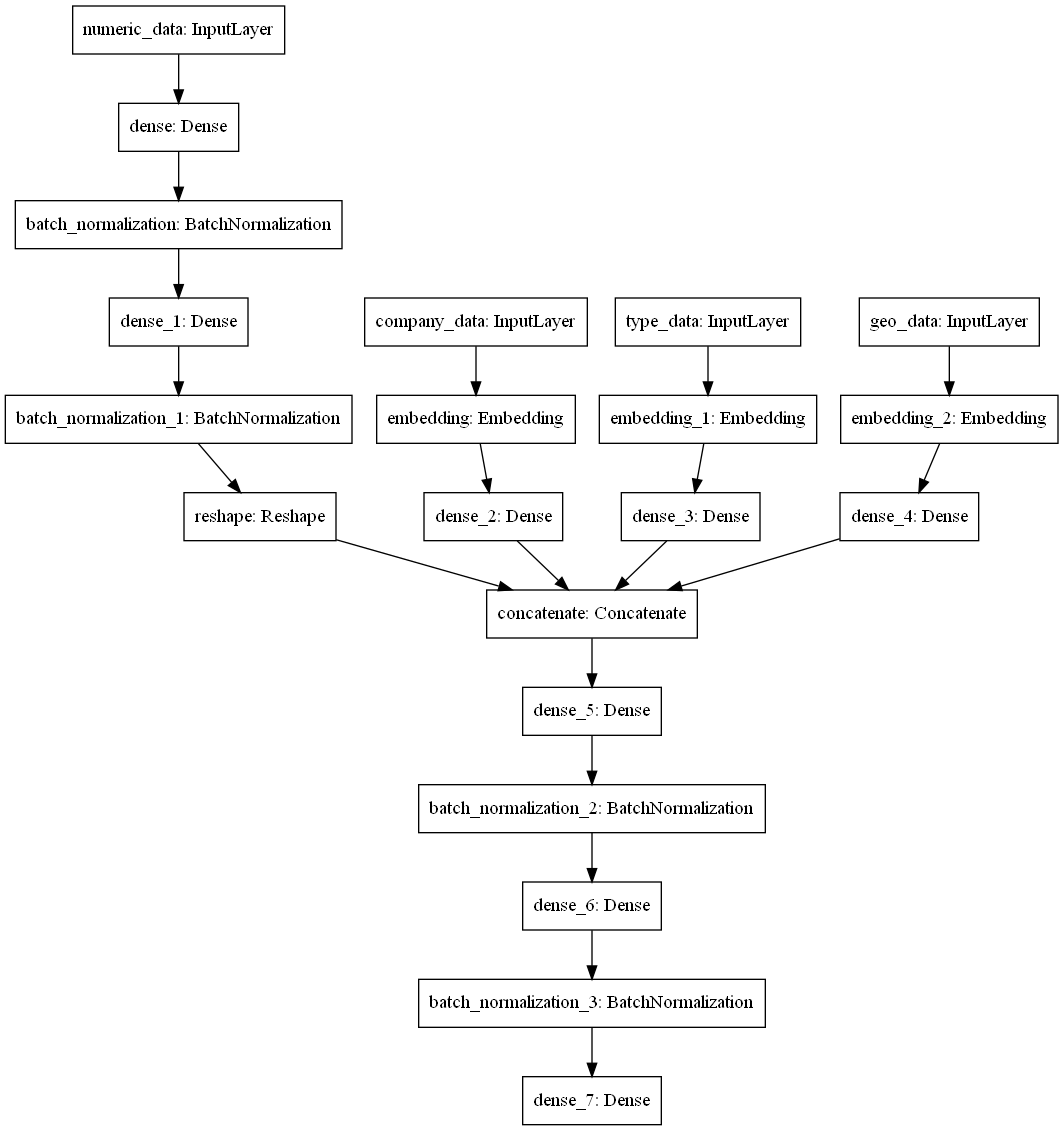

In [14]:
plot_model(model, to_file='model.png')

In [15]:
BATCH_SIZE = 128

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"numeric_data": X_train[numeric_cols].values, 
                          "company_data": X_train.company.values, 
                          "type_data": X_train.type.values, 
                          "geo_data": X_train.geo.values}, y_train))
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"numeric_data": X_valid[numeric_cols].values, 
                          "company_data": X_valid.company.values, 
                          "type_data": X_valid.type.values, 
                          "geo_data": X_valid.geo.values}, y_valid))
    .batch(BATCH_SIZE)

)

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./check_point',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-6)

In [17]:
%%time
n_steps = X_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=10, 
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
1125/1125 [==============================] - 6s 3ms/step - loss: 0.6828 - accuracy: 0.6393 - val_loss: 0.5070 - val_accuracy: 0.7492
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4962 - accuracy: 0.7528 - val_loss: 0.4662 - val_accuracy: 0.7686
Epoch 3/10
1125/1125 [==============================] - 5s 5ms/step - loss: 0.4719 - accuracy: 0.7622 - val_loss: 0.4514 - val_accuracy: 0.7718
Epoch 4/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4602 - accuracy: 0.7652 - val_loss: 0.4433 - val_accuracy: 0.7741
Epoch 5/10
1125/1125 [==============================] - 5s 4ms/step - loss: 0.4530 - accuracy: 0.7670 - val_loss: 0.4382 - val_accuracy: 0.7737
Epoch 6/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4479 - accuracy: 0.7677 - val_loss: 0.4347 - val_accuracy: 0.7745
Epoch 7/10
1125/1125 [==============================] - 4s 4ms/step - loss: 0.4441 - accuracy: 0.7691 - val_loss: 0.4321 - val_accuracy:

In [18]:
model.load_weights(filepath='./check_point')

In [19]:
predictions = model.evaluate([test_df[numeric_cols].values, 
                              test_df.company.values, 
                              test_df.type.values, 
                              test_df.geo.values], test_df.target, verbose=1)

1250/1250 [==============================] - 2s 2ms/step - loss: 0.4368 - accuracy: 0.7700
